In [84]:
### LIBRARIES / HEADER STUFF {
import json                  # Initial dataset import
from graphviz import Digraph # Primary renderer
### }

In [93]:
### Hyperparams {
REMOVEGRADCLASS = True
REQUIREMENTCOLOR = True
required = {'PHYS039','MATH009A','MATH009B','MATH009C','CHEM001A',
                'CHEM001B','CHEM001C','CS010','MATH010A','MATH010B','MATH046',
                'PHYS041A','PHYS041B','PHYS041C','PHYS130A','PHYS130B','PHYS132',
                'PHYS135A','PHYS135B','PHYS156A','PHYS156B','PHYS139L','PHYS142W'}
GROUPBOXES = False # Keep this false; the labeling system is better
remove_nonmajor = True
DARKTHEME = True
### }

In [94]:
### IMPORT FROM DATASET {

# Opens and autocloses the file, binds file to f, and loads the data
with open('/home/order/Dropbox/Python_Code/Cloned/ucr-course-graph/data/201740_all_prereqs.json','r') as f:
    data = json.load(f)

# Define course object
class course:
    def __init__(self, courseName, preReq, courseID, subject):
        self.courseName = courseName
        self.preReq = preReq
        self.courseID = courseID
        self.subject = subject

# Mildly brittle parser
def parseAndOr(testString):
    if testString == dict():
        return dict()
    if len(testString.split('\n')) < 3:
        return dict()
    if 'Score for' in testString: # EXTREMELY HACKY SOLUTION
        return dict()
    mod = testString.split('and\n')
    mod = [x.split('or\n') for x in mod]
    mod = [[y.split('\n') for y in x] for x in mod]
    # mod = [[[z for z in y] for y in x] for x in mod]
    def classconvert(classname):
        intermed = classname.split(' ')
        intermed = [' '.join(intermed[:-1]), intermed[-1]]
        lookup = {
            'Computer Science':'CS',
            'Physics':'PHYS',
            'Mathematics':'MATH',
            'Electrical Engineering':'EE',
            'Bioengineering':'BIEN',
            'Chemistry':'CHEM',
            'English':'ENGL',
            'Environmental Sciences':'ENSC',
            'Sociology':'SOC',
            'Mechanical Engineering':'ME',
            'Biology':'BIOL',
            'Business':'BUS',
            'Psychology':'PSYC',
            'Dance':'DNCE'
        }
        if intermed[0] in lookup:
            return lookup[intermed[0]] + intermed[1]
        else:
            return classname
    
    try:
        # This is the most horrific list comprehension I've every written, but it works
        mod = [[[
             classconvert(y[1][y[1].index('Test:')+6:].strip()), # Class name
             y[2].split(' ')[-1], # Grade
             'NC' if y[3].strip()[:7] == 'May not' else 'C' # Concurrent allowed?
                ] if y[0] == '(' else [
             classconvert(y[0][y[0].index('Test:')+6:].strip()), # Class name
             y[1].split(' ')[-1], # Grade
             'NC' if y[2].strip()[:7] == 'May not' else 'C' # Concurrent allowed?
                ] for y in x] for x in mod]
    except:
        print(testString)
        print(mod)
        raise
    return mod

courseList = []
for currentCourse in data:
    try: # Dealing with situations where prereq didn't get written
        mycourse = course(currentCourse['subjectCourse'], parseAndOr(currentCourse['prereqs']), currentCourse['id'], currentCourse['subject'])
    except KeyError:
        mycourse = course(currentCourse['subjectCourse'], dict(), currentCourse['id'], currentCourse['subject'])
    courseList.append(mycourse) # Writes course objects to a list

for i in courseList:
    if i != dict():
        print(i.preReq)

### }

{}
{}
{}
{}
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
[[['Anthropology 003', 'D-', 'NC'], ['Anthropology 005', 'D-', 'NC']]]
[[['Anthropology 003', 'D-', 'NC'], ['Anthropology 005', 'D-', 'NC']]]
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']], [['Linguistics 020', 'D-', 'NC']]]
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
[[['Linguistics 020', 'D-', 'NC']]]
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
[[['Anthropology 002', 'D-', 'NC']]]
[[['Anthropology 002', 'D-', 'NC']]]
{}
[[['Anthropology 001', 'D-', 'NC'], ['Anthropology 001H', 'D-', 'NC'], ['Anthropology 001W', 'D-', 'NC']]]
{}
[[['Arabic Language 003', 'C-', 'NC']]]
{}
{}
{}
{}
{}
{}
{}
{}
{}
[[['Art 001', 'D-', 'NC']], [['Art 002', 'D-', 'NC']]]
[[['Art 001', 'D-', 'NC']], [['Art 002

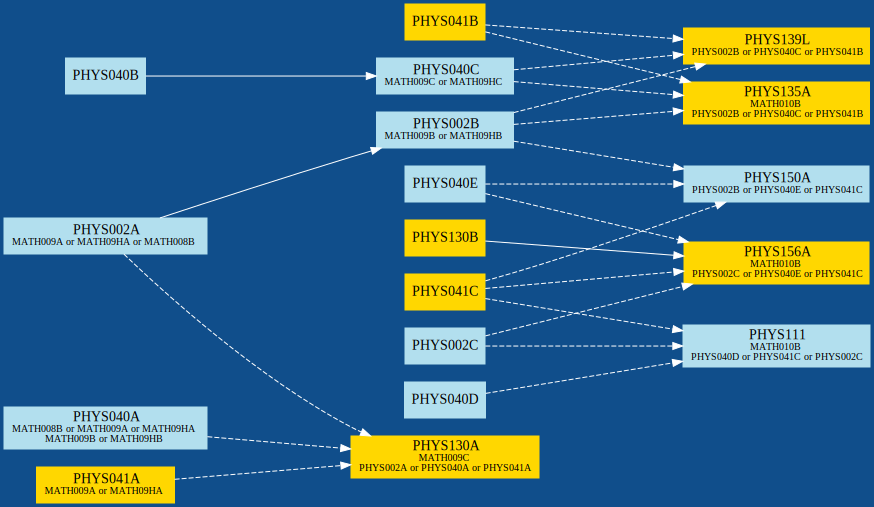

In [113]:
### RENDER GRAPH {

def undergradOnly(courseList):
    numbers = set('0123456789')
    return [x for x in courseList if [y for y in x.courseName if y in numbers][0] in {'0','1'}]

def selectMajor(courseList,major):
    # Use 4-code for major (eg 'PHYS')
    return [x for x in courseList if x.subject == major]
    # return [x for x in courseList if x.subject in ['PHYS','ME','SOC','CHEM','CS','EE','ENSC','BIOL','BUS','DNCE','PSYC']]

len(courseList)
len(selectMajor(courseList,'PHYS'))

major = 'PHYS'
if REMOVEGRADCLASS:
    physList = undergradOnly(selectMajor(courseList,major))
else:
    physList = selectMajor(courseList,major)

if DARKTHEME:
    dot = Digraph(comment='classflow test',graph_attr={'rankdir': 'LR', 'ranksep': '2', 'overlap': 'false', 'bgcolor':'dodgerblue4'})
else:
    dot = Digraph(comment='classflow test',graph_attr={'rankdir': 'LR', 'ranksep': '2', 'overlap': 'false'})

# Robustly add new classes (on a new line) to the labels inside the nodes
def safeAddLabel(course_name, new_prereq):
    dotline = [x for x in dot.__dict__['body'] if x.split(' ')[0][1:] == course_name and 'label=' in x]
    if dotline: # non-empty
        dotline = dotline[0]
        def addPrereqHTML(label,new_prereq):
            posn = label.index('</FONT>')
            return label[:posn] + '<br />' + new_prereq + label[posn:]
        newlabel = addPrereqHTML(dotline[dotline.index('label=')+6:-1],new_prereq)
        dot.node(course_name,label=newlabel)
    else: # No label currently on the bottom, so initialize it
        dot.node(course_name,label='<' + course_name + '<br /><FONT POINT-SIZE="10">' + new_prereq +'</FONT>>')

# Define how to draw between courses (with all the relevant conditions)
def requisiteLine(fromCourse,toCourse,graph,fromOrGroup=False,**args):
    """fromCourse example: "['ANTH001', 'D-', 'NC']"
       toCourse example: "course" object with courseName, etc.
       Creates nodes on both ends, then draws the requisite line between the two of them.
       Also references the global required list"""
    
    shape = 'box'
    
    ### ALTERNATE ROUTE: If one of the edges isn't a part of the major, instead make a label under the
    ### class pointed to, then ignore the edge initialization
    if remove_nonmajor:
        # Uses same code as not remove_nonmajor, but intelligently changes the iterator
        numbers = set('0123456789')
        for i,x in enumerate(fromCourse[0]):
            if x in numbers:
                index = i
                break
        condition = fromCourse[0][:index]
        iterator = [fromCourse[0],toCourse.courseName] if condition == major else [toCourse.courseName]
        # Create nodes
        if REQUIREMENTCOLOR:
            for toNode in iterator:
                if toNode in required:
                    graph.node(toNode,style='filled',color='gold',shape=shape)
                else:
                    graph.node(toNode,style='filled',color='lightblue2',shape=shape)
        else:
            for toNode in iterator:
                graph.node(toNode,shape=shape)
        # Since edge auto-creates nodes, now only run if len(iterator) == 2.
        if len(iterator) == 2:
            if DARKTHEME:
                graph.edge(fromCourse[0],toCourse.courseName,color='white',**args)
            else:
                graph.edge(fromCourse[0],toCourse.courseName,color='black',**args)
        else: # If not, add a label for the missing class (unless already written as a part of the orGroup)
            if not fromOrGroup:
                safeAddLabel(toCourse.courseName,fromCourse[0])
        
    else:
        # Create nodes
        if REQUIREMENTCOLOR:
            for toNode in [fromCourse[0],toCourse.courseName]:
                if toNode in required:
                    graph.node(toNode,style='filled',color='gold',shape=shape)
                else:
                    graph.node(toNode,style='filled',color='lightblue2',shape=shape)
        else:
            for toNode in [fromCourse[0],toCourse.courseName]:
                graph.node(toNode,shape=shape)
        
        # Draw line
        if DARKTHEME:
            graph.edge(fromCourse[0],toCourse.courseName,color='white',**args)
        else:
            graph.edge(fromCourse[0],toCourse.courseName,color='black',**args)

# Create lines between courses
runID = 0
for i in physList:
    if i.preReq != dict():
        # i.preReq is "and_group"
        for orGroup in i.preReq:
            if len(orGroup) > 1:
                for j in orGroup:
                    requisiteLine(j,i,dot,style='dashed', fromOrGroup=True)
                # Now add the or group as a prereq under the node
                # Be careful to not overwrite other labels; automatically do a <BR /> if needed.
                safeAddLabel(i.courseName,' or '.join([x[0] for x in orGroup]))
            else:
                requisiteLine(orGroup[0],i,dot)

# dot.node('PHYS041B',label='<PHYS041B<br /><FONT POINT-SIZE="10">yes<br />yes<br />yes</FONT>>')
dot

In [114]:
dot.render(filename='./test',view=True,format='png')

'./test.png'

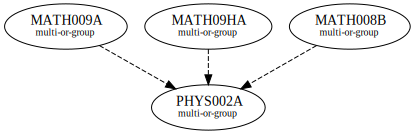

In [57]:
dot

In [109]:
help(dot.render)

Help on method render in module graphviz.files:

render(filename=None, directory=None, view=False, cleanup=False, format=None, renderer=None, formatter=None) method of graphviz.dot.Digraph instance
    Save the source to file and render with the Graphviz engine.
    
    Args:
        filename: Filename for saving the source (defaults to ``name`` + ``'.gv'``)
        directory: (Sub)directory for source saving and rendering.
        view (bool): Open the rendered result with the default application.
        cleanup (bool): Delete the source file after rendering.
        format: The output format used for rendering (``'pdf'``, ``'png'``, etc.).
        renderer: The output renderer used for rendering (``'cairo'``, ``'gd'``, ...).
        formatter: The output formatter used for rendering (``'cairo'``, ``'gd'``, ...).
    Returns:
        The (possibly relative) path of the rendered file.
    Raises:
        ValueError: If ``format``, ``renderer``, or ``formatter`` are not known.
       